# Dreem Data Challenge

Equipe : Anthony Pansard & Félix Hubert

Nom de l'équipe sur le challenge kaggle : FELIX_ANTHONY

## A. Exploration et prétraitement des données

Les données sont des signaux enregistrés par le bandeau de la start-up Dreem. Chaque donnée comporte 30s de divers signaux :
- 7 électroencéphalogrammes (EEG)
- accéléromètre selon les directions x,y et z
- L'oxymétrie de pouls

Nous devons classifier les données selon 5 catégories correspondant à 5 cycles de sommeil.

Les données étiquettés sur lesquelles nous allons entrainer notre modèle comporte 24688 instances réparties selon 31 patients.

On observe d'emblé une répartition non-équilibrée des différentes classes dans les données, avec seulement 1671 données pour le cycle de sommeil de type 1, ce qui présentera un défi pour le classifier correctement. On remarque la présence de nombreux artefacts, notamment beaucoup d'éléctrodes eeg captant des signaux supérieurs à 1000 micro-volt, ce qui n'est pas possible biologiquement. 

In [2]:
import numpy as np
import pandas as pd
import h5py

# importation des données d'entrainement

with h5py.File("X_train.h5", 'r') as h5:

    eegs = dict()
    eegs[1]=np.array(h5["eeg_1"])
    eegs[2]=np.array(h5["eeg_2"])
    eegs[3]=np.array(h5["eeg_3"])
    eegs[4]=np.array(h5["eeg_4"])
    eegs[5]=np.array(h5["eeg_5"])
    eegs[6]=np.array(h5["eeg_6"])
    eegs[7]=np.array(h5["eeg_7"])
    
    index = np.array(h5["index"])
    index_absolute = np.array(h5["index_absolute"])
    index_window = np.array(h5["index_window"])
    
    pulse = np.array(h5["pulse"])
    
    x = np.array(h5["x"])
    y = np.array(h5["y"])
    z = np.array(h5["z"])
    
    print("liste des variables :")
    print(list(h5.keys()))

liste des variables :
['eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7', 'index', 'index_absolute', 'index_window', 'pulse', 'x', 'y', 'z']


In [3]:
# importation des étiquettes des données

labels = pd.read_csv("y_train.csv")
sleep_stage_indexes = dict(iter(labels.groupby("sleep_stage")))
print("nombre total de données :",len(labels))
for key in sleep_stage_indexes.keys():
    print("cycle de sommeil",key,", nombre de données :",len(sleep_stage_indexes[key]))

nombre total de données : 24688
cycle de sommeil 0 , nombre de données : 3511
cycle de sommeil 1 , nombre de données : 1671
cycle de sommeil 2 , nombre de données : 9449
cycle de sommeil 3 , nombre de données : 5224
cycle de sommeil 4 , nombre de données : 4833


<IPython.core.display.Javascript object>


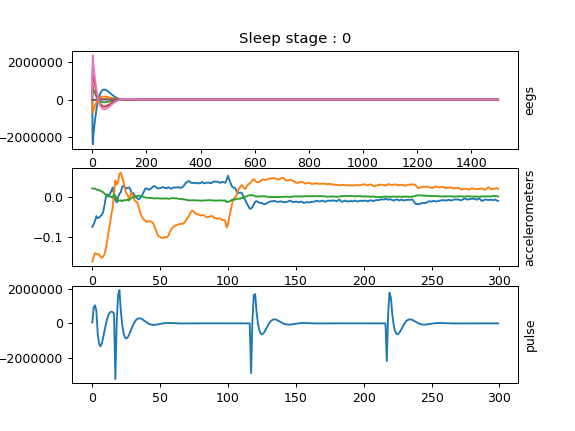

interactive(children=(FloatSlider(value=0.0, description='w', max=1000.0, step=1.0), Output()), _dom_classes=(…

In [4]:
%matplotlib notebook
from ipywidgets import *
import matplotlib.pyplot as plt

# visualisation interactive des données

fig = plt.figure()
ax = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

def update(w = 1.0):
    ax.clear()
    ax2.clear()
    ax3.clear()
    
    ax.set_ylabel("eegs")
    ax2.set_ylabel("accelerometers")
    ax3.set_ylabel("pulse")
    ax.yaxis.set_label_position("right")
    ax2.yaxis.set_label_position("right")
    ax3.yaxis.set_label_position("right")
    
    ax.set_title( "Sleep stage : "+ str(labels["sleep_stage"][int(w)]))
    ax.plot(eegs[1][int(w)])
    ax.plot(eegs[2][int(w)])
    ax.plot(eegs[3][int(w)])
    ax.plot(eegs[4][int(w)])
    ax.plot(eegs[5][int(w)])
    ax.plot(eegs[6][int(w)])
    ax.plot(eegs[7][int(w)])
    
    ax2.plot(x[int(w)]-np.mean(x[int(w)]))
    ax2.plot(y[int(w)]-np.mean(y[int(w)]))
    ax2.plot(z[int(w)]-np.mean(z[int(w)]))
    
    ax3.plot(pulse[int(w)])
    
    fig.canvas.draw_idle()

interact(update, w = widgets.FloatSlider(value=0,
                                               min=0,
                                               max=1000,
                                               step=1));

plt.show()

## B. Extraction des features

Ils existent de nombreuses features pouvant être extraite d'un signal EEG, détaillées dans l'article scientifique disponible sur la page du challenge kaggle. La fréquence de sampling des signaux étant de 50Hz, elle est au moins deux fois plus basse que les fréquences de sampling utilisées dans les divers articles scientifiques présentées, certaines mesures seront donc moins intéréssantes que prévu.

Nous avons, après une étape de sélection de features, choisi de représenter un signal EEG par 33 features.

D'abord des mesures statistiques et de puissance de bande fréquentielle liées à chacunes des bandes de fréquences d'ondes caractéristiques des différentes cycle de sommeil :
- onde delta entre 0.5 et 4Hz
- onde theta entre 4 et 8Hz
- onde alpha entre 8 et 13Hz
- onde beta entre 13 et 22Hz

La fréquence de sampling à 25Hz nous empêche de récupérer des informations sur la dernière bande de fréquence relative au sommeil, les ondes gamma (plus de 25Hz), c'est le théorème de Shannon (repliage du spectre).

Ensuite, en s'inspirant d'articles scientifiques, on ajoute des features lié à l'entropie du signal EEG et sa dimension fractale.Les features MMD et ESIS présenté dans l'article de Dreem sont également calculées.

En complément des features du signal d'un capteur EEG, on extrait la variance des signaux x,y et z correspondant aux mouvements de la tête du patient. La variance du signal pulse et son zero crossing nous donnent également des informations sur le pouls du sujet.

In [5]:
from tqdm.notebook import tqdm
from scipy.integrate import simps
from scipy import signal
# entropy package need special installation https://github.com/raphaelvallat/entropy
from entropy import *
import scipy.stats

# fréquence de sampling
fs = 50

# fréquences limites des différentes bandes d'ondes du sommeil
cut_delta = [0.5,4]
cut_theta = [4,8]
cut_alpha = [8,13]
cut_beta = [13,22]


# création d'un filtre passe-bande
def butter_bandpass(lowcut,highcut,fs,order=5):
    nyq = 0.5*fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

# fonction de filtrage d'un signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y


# bandfilter eeg signal into different sleep_waves frequency range
def clean_data(s) :
    
    filtered_delta = butter_bandpass_filter(s,cut_delta[0],cut_delta[1],fs)
    filtered_theta = butter_bandpass_filter(s,cut_theta[0],cut_theta[1],fs)
    filtered_alpha = butter_bandpass_filter(s,cut_alpha[0],cut_alpha[1],fs)
    filtered_beta = butter_bandpass_filter(s,cut_beta[0],cut_beta[1],fs)
    
    eeg_propre = filtered_delta+filtered_theta+filtered_alpha+filtered_beta
    
    return(eeg_propre,filtered_delta,filtered_theta,filtered_alpha,filtered_beta)

# compute mmd dreem feature
def get_mmd(s):
    bin_size = 100
    d = 0
    for i in range(len(s)//bin_size):
        d += np.sqrt( (np.argmax(s[i*bin_size:i*bin_size+99])-np.argmin(s[i*bin_size:i*bin_size+99]))**2 + (np.max(s[i*bin_size:i*bin_size+99])-np.min(s[i*bin_size:i*bin_size+99]))**2 )
    return d

# compute esis dreem feature
def get_esis(s,f_cut):
    d = 0
    X = sum(map(lambda x:x*x,s))
    return(X*100*(10**-6)*(f_cut[0]+f_cut[1])/2)


def get_features(s):

    # compute the relative bandpower of each sleepwaves band
    win = 4 * fs * 0.5
    freqs, psd = signal.welch(s, fs, nperseg=win)
    freq_res = freqs[1]-freqs[0]

    idx_delta = np.logical_and(freqs >= cut_delta[0], freqs <= cut_delta[1])
    idx_theta = np.logical_and(freqs >= cut_theta[0], freqs <= cut_theta[1])
    idx_alpha = np.logical_and(freqs >= cut_alpha[0], freqs <= cut_alpha[1])
    idx_beta = np.logical_and(freqs >= cut_beta[0], freqs <= cut_beta[1])
    
    delta_power = simps(psd[idx_delta], dx=freq_res)
    theta_power = simps(psd[idx_theta], dx=freq_res)
    alpha_power = simps(psd[idx_alpha], dx=freq_res)
    beta_power = simps(psd[idx_beta], dx=freq_res)
    
    total_power= simps(psd, dx=freq_res)
    
    bandpowers = [total_power]
    bandpowers.append(delta_power/total_power)
    bandpowers.append(theta_power/total_power)
    bandpowers.append(alpha_power/total_power)
    bandpowers.append(beta_power/total_power)
    
    # statistic moments for each frequency band
    cleaned = clean_data(s)
    # means = [ np.mean(sig) for sig in cleaned ]
    varss = [np.std(sig) for sig in cleaned ]
    # skew =  [ scipy.stats.skew(sig) for sig in cleaned ]
    kurtosis = [ scipy.stats.kurtosis(sig) for sig in cleaned]
    
    # dreem measures 
    f_cuts=[cut_delta,cut_theta,cut_alpha,cut_beta]
    mmds = [ get_mmd(cleaned[i]) for i in range(1,5) ]
    esiss = [ get_esis(cleaned[i],f_cuts[i-1]) for i in range(1,5) ]
    
    # other measures : zero crossings, few types of entropies and fractal dimensions
    zero_crossings = [ ((sig[:-1] * sig[1:]) < 0).sum() for sig in cleaned]
    entropies = [ app_entropy(s, order=2, metric='chebyshev'),
                  sample_entropy(s, order=2, metric='chebyshev') ]
    fractal_dims = [petrosian_fd(s),katz_fd(s),higuchi_fd(s, kmax=10)]
    
    return(bandpowers+varss+kurtosis+zero_crossings+mmds+esiss+entropies+fractal_dims)

i = 1000
features= get_features(eegs[1][i])
print("on extrait %s features d'un seul signal eeg." %len(features))

eeg_features = [
    "total_power", "bandpower_delta","bandpower_theta","bandpower_alpha","bandpower_beta",
    "total_var", "var_delta","var_theta","var_alpha","var_beta",
    "total_kurtosis", "kurtosis_delta","kurtosis_theta","kurtosis_alpha","kurtosis_beta",
    "zero_crossings_total","zero_crossings_delta","zero_crossings_theta","zero_crossings_alpha","zero_crossings_beta",
    "mmd_delta","mmd_theta","mmd_alpha","mmd_beta",
    "esis_delta","esis_theta","esis_alpha","esis_beta",
    "app_entropy","sample_entropy",
    "petrosian_fd","katz_fd","higuchi_fd"
]

print("liste des features:", ", ".join(eeg_features))
len(eeg_features)

on extrait 33 features d'un seul signal eeg.
liste des features: total_power, bandpower_delta, bandpower_theta, bandpower_alpha, bandpower_beta, total_var, var_delta, var_theta, var_alpha, var_beta, total_kurtosis, kurtosis_delta, kurtosis_theta, kurtosis_alpha, kurtosis_beta, zero_crossings_total, zero_crossings_delta, zero_crossings_theta, zero_crossings_alpha, zero_crossings_beta, mmd_delta, mmd_theta, mmd_alpha, mmd_beta, esis_delta, esis_theta, esis_alpha, esis_beta, app_entropy, sample_entropy, petrosian_fd, katz_fd, higuchi_fd


33

In [6]:
# création des features pour les 7 capteurs EEG
'''
import pickle

for j in range(1,8):
    filename='features_VF_eeg_'+str(j)
    outfile = open(filename,'wb')
    X_features=[]
    for i in tqdm(range(len(eegs[j]))):
         X_features.append(get_features(eegs[j][i]) +[np.var(x[i]),np.var(y[i]),np.var(z[i]),np.var(pulse[i]),((pulse[i][:-1] * pulse[i][1:]) < 0).sum()] )
    pickle.dump(X_features,outfile)
    outfile.close()  
'''

print("done.")

done.


## C. Description du modèle utilisé

Si on choisit de créér ainsi 7 ensembles de features différents associé aux 7 capteurs EEG, c'est pour entrainer 7 sous-modèles et faire un système de vote qui permettra d'éviter des erreurs dû aux artefacts d'un ou plusieurs capteurs lors d'une mesure. 

### Sous-modèle 

Après de nombreux tests de modèles, on choisit d'utiliser le modèle XGBoost comme sous-modèle, pour ses performances optimales et sa rapidité. La librarie XGBoost implemente un algorithme de gradient boosting decision tree. L'algorithme construit des decision trees qu'il ajoute successivement au modèle pour réduire l'erreur de l'étape précedente jusqu'a ce qu'il ne puisse plus améliorer significativement le resultat. La fonction d'erreur utilisée est une log-loss multiclasse. Le modèle XGboost est aussi capable de fournir les probabilités des prédictions, ce qui nous a été utile pour le filtre Hidden Markov Models (HMM).

Pour valider notre modèle, on laisse de côté les données de septs patient lors de l'entrainement, sur lesquelles nous calculerons les performances de notre modèle. C'est plus informatif que de simplement prendre 20% de données au hasard, vu que les vrais données tests sont prises sur d'autres patients.

In [7]:
# on récupère les features depuis les fichiers statiques

import pickle
from sklearn.model_selection import train_test_split 

X_train = dict()
X_test = dict()
y_train = dict()
y_test = dict()
X_feats = dict()

for i in range(1,8):
    X_features = []
    infile = open('features_V2_eeg_'+str(i),'rb')
    X_features = pickle.load(infile)
    infile.close()
    # ensemble des features pour chaque capteur EEG
    X_feats[i] = X_features
    # séparation des features en 24 premiers sujets et 7 derniers patients pour la futur validation du modèle
    # avec shuffle=False on s'assure que les données restent ordonnées, ce qui sera important pour le filtre HMM
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X_features,labels['sleep_stage'],train_size=19831,shuffle=False,random_state = 123)
print("en ajoutant des informations sur les signaux x,y,z et pulse, on obtient %s features par signaux eeg." %len(X_feats[1][0]))

en ajoutant des informations sur les signaux x,y,z et pulse, on obtient 38 features par signaux eeg.


In [8]:
# on normalise nos données, ce qui améliore le score sur tout les types de modèles
# même si il n'y a pas de différence théorique pour les arbres de décisions
from sklearn.preprocessing import StandardScaler

scalers = {i : StandardScaler() for i in range(1,8)}

X_train_scale = dict()
X_test_scale = dict()
X_feats_scale = dict()
for i in range(1,8):
    X_feats_scale[i] = scalers[i].fit_transform(X_feats[i])
    X_train_scale[i] = scalers[i].transform(X_train[i])
    X_test_scale[i] = scalers[i].transform(X_test[i])

## D. Protocole de validation croisée pour le choix des hyperparamètres du modèle

On utilise la fonction scikit *RandomizeSearchCV* pour trouver les paramètres optimaux du sous-modèles sur un capteur EEG. Cela nous donne un validation croisée des paramètres optimaux des sous-modèles.

Nous trouvons pour le sous-modèle xgboost les paramètres d'entrainement optimaux suivant :
- 'subsample': 1.0        *Fraction des observations à être sample aléatoirement pour chaque arbre*
- 'min_child_weight': 1   *La somme minimale des poids de toutes les observations requises pour un enfant*
- 'max_depth': 8          *Profondeur maximale d'un arbre de décision*
- 'gamma': 1              *Réduction de la fonction de loss nécéssaire pour split un node*
- 'colsample_bytree': 0.8 *Fraction des colonnes à être sample aléatoirement pour chaque arbre*

In [10]:
# recherche des paramètres optimales pour un sous-modèle 
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

folds = 3 # # à mettre au maximum compatible avec la puissance de l'ordinateur
param_comb = 30 # à mettre au maximum compatible avec la puissance de l'ordinateur

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4,5,6,8],
        }


clf = RandomizedSearchCV( 
    xgb.XGBClassifier(learning_rate = 0.3,use_label_encoder=False,verbosity = 0),
    param_distributions= param_grid,n_iter=param_comb,
    cv=skf.split(np.array(X_train_scale[1]), y_train[1]), verbose=2, 
    random_state=1001 
)


clf = clf.fit(np.array(X_train_scale[1]), y_train[1])


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()


'''
Best parameters set found on development set:

{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 6, 'gamma': 0.5, 'colsample_bytree': 0.6}

Grid scores on development set:

0.780 (+/-0.011) for {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
0.782 (+/-0.010) for {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 2, 'colsample_bytree': 0.8}
0.786 (+/-0.005) for {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 6, 'gamma': 0.5, 'colsample_bytree': 0.6}
0.786 (+/-0.008) for {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 1, 'colsample_bytree': 0.6}
0.778 (+/-0.005) for {'subsample': 0.6, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 1, 'colsample_bytree': 0.8}
0.783 (+/-0.003) for {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 8, 'gamma': 2, 'colsample_bytree': 0.8}
0.767 (+/-0.007) for {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 5, 'colsample_bytree': 0.8}
0.786 (+/-0.009) for {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 1.5, 'colsample_bytree': 0.6}
0.781 (+/-0.000) for {'subsample': 1.0, 'min_child_weight': 10, 'max_depth': 6, 'gamma': 2, 'colsample_bytree': 0.6}
0.784 (+/-0.007) for {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 1.5, 'colsample_bytree': 0.6}
0.776 (+/-0.003) for {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
0.785 (+/-0.002) for {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 1.5, 'colsample_bytree': 0.8}
0.780 (+/-0.008) for {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 8, 'gamma': 1.5, 'colsample_bytree': 1.0}
0.785 (+/-0.012) for {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.6}
0.767 (+/-0.004) for {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 5, 'colsample_bytree': 0.6}
0.777 (+/-0.005) for {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.6}
0.782 (+/-0.008) for {'subsample': 1.0, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 1.0}
0.773 (+/-0.009) for {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 8, 'gamma': 5, 'colsample_bytree': 1.0}
0.777 (+/-0.006) for {'subsample': 0.6, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 1, 'colsample_bytree': 1.0}
0.781 (+/-0.005) for {'subsample': 0.6, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 0.5, 'colsample_bytree': 0.6}
0.780 (+/-0.003) for {'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 2, 'colsample_bytree': 0.8}
0.783 (+/-0.006) for {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 8, 'gamma': 1, 'colsample_bytree': 0.8}
0.785 (+/-0.008) for {'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 6, 'gamma': 1, 'colsample_bytree': 0.8}
0.771 (+/-0.001) for {'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 5, 'colsample_bytree': 0.6}
0.771 (+/-0.003) for {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 5, 'colsample_bytree': 0.6}
0.779 (+/-0.006) for {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 6, 'gamma': 2, 'colsample_bytree': 0.6}
0.778 (+/-0.005) for {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1, 'colsample_bytree': 0.8}
0.785 (+/-0.006) for {'subsample': 1.0, 'min_child_weight': 10, 'max_depth': 8, 'gamma': 1.5, 'colsample_bytree': 0.6}
0.773 (+/-0.008) for {'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 6, 'gamma': 5, 'colsample_bytree': 1.0}
0.775 (+/-0.005) for {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
'''

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=5, subsample=1.0; total time=  17.2s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=5, subsample=1.0; total time=  18.3s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=5, subsample=1.0; total time=  16.9s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=1, subsample=0.8; total time=  27.7s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=1, subsample=0.8; total time=  26.0s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=1, subsample=0.8; total time=  25.5s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=6, min_child_weight=5, subsample=1.0; total time=  21.2s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=6, min_child_weight=5, subsample=1.0; total time=  19.5s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=6, min_child_weight=5

In [11]:
# entrainement des sous-modèles avec les paramètres optimaux
import xgboost as xgb

models = dict()
for j in tqdm(range(1,8)):
    models[j] = xgb.XGBClassifier(learning_rate = 0.3,
                                  subsample=1,
                                  min_child_weight=5,
                                  max_depth=6,
                                  gamma=0.5,
                                  colsample_bytree=0.6,
                                  use_label_encoder=False,
                                  verbosity = 0).fit(np.array(X_train_scale[j]), y_train[j])


### Amélioration des prédictions du sous-modèle avec un Filtre HMM (Hidden Markov Model)

Pour exploiter les relations temporelles entre les classes des données, qui existent car elles sont ordonnées temporellement selon le déroulé des nuits des patients, on a choisit un modèle simple, un filtre Hidden Markov Model qui prend en entrée la matrice de transition estimée à partir de la prédiction, les probabilités d'appartenances à chaque classe calculées par le sous-modèle, et corrige les prédictions en utilisant l'*algorithme de Viterbi*. Cela nous permet de gagner environ 1% sur notre score.

In [70]:
# prédiction et vote de la prédiction finale
from hmm_filter.hmm_filter import HMMFilter

# turn list of probabilites into dictionnary of probabilities
def format_proba(p_list):
    p_dict={}
    for i in range(5):
        p_dict[i] = p_list[i]
    return(p_dict)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
from collections import Counter

submodels_predictions = dict()
predictions_proba = dict()
predictions_hmm = dict()

# pour chaque sous-modèle
for j in tqdm(range(1,8)):
    
    # on prédit la classe de la donnée
    submodels_predictions[j] = models[j].predict(np.array(X_test_scale[j]))
    
    # on sauvegarde les probabilités associées à chaqune des classes pour la donnée
    predictions_proba[j] = models[j].predict_proba(np.array(X_test_scale[j]))

    # on entraine un Hidden Markov Model sur les étiquettes d'entrainement
    # pour obtenir une matrice de transition entre chaque classe
    # en considérant que les données se suivent
    table = pd.DataFrame()
    table["true_labels"] = y_train[j]
    table["session_column"] = [0 for i in range(19831)]
    hmmfilter = HMMFilter()
    hmmfilter.fit(table, session_column="session_column", prediction_column="true_labels")
    
    # on corrige les prédictions grâce à l'algorithme de Viterbi
    table_test = pd.DataFrame()
    table_test["prediction"] = submodels_predictions[j]
    table_test["probabs"] = [ format_proba(predictions_proba[j][k]) for k in range(len(submodels_predictions[1]))]
    table_test["session_column"] = [0 for i in range(19831,24688)]

    corrected_pred_hmm = hmmfilter.predict(table_test, session_column="session_column", 
                                probabs_column="probabs",prediction_column="prediction")
    
    predictions_hmm[j] = list(corrected_pred_hmm.prediction)
    

### Système de vote

On va maintenant combiner les prédictions de chaque sous-modèle pour améliorer la prédiction des étiquettes, par un système de vote permettant de ne pas prendre en compte les prédictions fausses résultantes des artefacts.

Un premier système de vote prenant simplement en compte la majorité des 7 prédictions des sous-modèles pour la donnée donnait de bon résultat, mais le lissage induit par le HMM n'est pas favorable à la classe 1. On ajoute un trucage en faveur de la classe 1 pour améliorer le F1 score moyenné, qui est le score du challenge kaggle. Pour cela on fait la prédiction classe 1 dès qu'un un est prédit par un des sous-modèle xgboost.


In [75]:
# vote avec truage pour la classe 1
phase1 = [i for i in range(len(submodels_predictions[1])) if len([submodels_predictions[j][i] for j in range(1,8) if submodels_predictions[j][i] == 1])>1 and Counter([submodels_predictions[j][i] for j in range(1,8)]).most_common()[0][1]<6]
hmm_pred  = np.array([Counter([predictions_hmm[j][i] for j in range(1,8)]).most_common()[0][0] if i not in phase1 else 1 for i in range(len(predictions_hmm[1]))])

[(2, 2433), (3, 976), (4, 693), (0, 504), (1, 251)]


## E. Résultats

Le système de vote est truqué en faveur de la classe 1 qui est la plus difficile à prédire : la règle est d'attribuer la classe 1 à la donnée si la classe 1 est prédite par au moins un des sous-modèles et si aucune des autres classes n'est prédite en majorité absolue par les autres sous-modèles.

Nous obtenons nos résultats sur nos 20% de données de test.

<IPython.core.display.Javascript object>


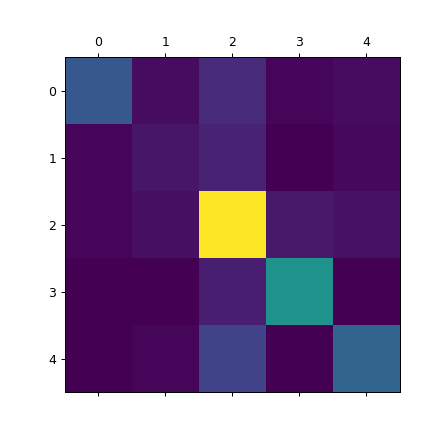

              precision    recall  f1-score   support

           0       0.89      0.58      0.70       776
           1       0.38      0.30      0.34       316
           2       0.67      0.85      0.75      1904
           3       0.86      0.86      0.86       974
           4       0.76      0.60      0.67       887

    accuracy                           0.73      4857
   macro avg       0.71      0.64      0.66      4857
weighted avg       0.74      0.73      0.72      4857

submodels mean F1 score without HMM: 0.5698255104131288
submodels mean F1 score with HMM: 0.6023209469727651

F1 score with vote 0.6896493718887127


In [77]:
# creating a confusion matrix & get score of model
%matplotlib notebook
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score

cm = confusion_matrix(y_test[1],hmm_pred) 
plt.matshow(cm)
plt.show()

print(classification_report(y_test[1], hmm_pred))

# score utilisé pour le leaderboard kaggle

print("submodels mean F1 score without HMM:",np.mean( [ fbeta_score(y_test[1],submodels_predictions[i],average='macro',beta=0.5) for i in range(1,8)])) 
print("submodels mean F1 score with HMM:",np.mean( [ fbeta_score(y_test[1],predictions_hmm[i],average='macro',beta=0.5) for  i in range(1,8)]))

print("")

print("F1 score with vote", fbeta_score(y_test[1],hmm_pred,average='macro',beta=0.5) )

## F. Conclusion

La prédiction des phases de sommeil par machine learning est un exercice challengeant. Les variabilités d'un patient à l'autre sont grandes, il est donc difficile d'éviter l'overfitting. Chaque capteur capte des signaux differents, et il faut donc faire un algorithme qui distingue chaque électrode, et trouver les meilleures façon de réunir les prédictions de chaque capteur pour faire la prédiction finale. Les phases de sommeil d'une nuit ne sont pas indépendantes les unes des autres (on reste generalement un certain temps, supérieur à 30 secondes, dans chaque phase), il fallait donc aussi réussir à prendre en compte les liens temporels entre les échantillons. Le modèle que nous proposons répond à ces problematiques et obtient des résultats qui nous semblent satisfaisant, bien qu'il soit encore perfectibles.

## G. Classification des données à prédire
Pour classifier les données de test, on va d'abord ré-entrainer notre modèle sur 100% des données disponibles.

In [80]:
Y = labels["sleep_stage"]
models_tot = dict()
for j in tqdm(range(1,8)):
    models_tot[j] = xgb.XGBClassifier(learning_rate = 0.3,
                                  subsample=1,
                                  min_child_weight=5,
                                  max_depth=6,
                                  gamma=0.5,
                                  colsample_bytree=0.6,
                                  use_label_encoder=False,
                                  verbosity = 0).fit(np.array(X_feats_scale[j]), Y)

[19:14:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [83]:
# récupération des features pré-calculés des données de test 

X = dict()
for i in range(1,8):
    X_features = []
    infile = open('features_dreem_'+str(i)+'_test_n','rb')
    X_features = pickle.load(infile)
    infile.close()
    X[i] = X_features

In [87]:
# prédiction

X_scale = dict()

for i in range(1,8):
    X_scale[i] = scalers[i].transform(X[i])

submodels_predictions = dict()
predictions_proba = dict()
predictions_hmm = dict()

# pour chaque sous-modèle
for j in tqdm(range(1,8)):
    
    # on prédit la classe de la donnée
    submodels_predictions[j] = models_tot[j].predict(np.array(X_test_scale[j]))
    
    # on sauvegarde les probabilités associées à chaqune des classes pour la donnée
    predictions_proba[j] = models_tot[j].predict_proba(np.array(X_test_scale[j]))

    # on entraine un Hidden Markov Model pour obtenir une matrice de transition entre chaque classe
    table = pd.DataFrame()
    table["prediction"] = submodels_predictions[j]
    table["subject_id"] = [0 for i in range(len(submodels_predictions[j]))]
    hmmfilter = HMMFilter()
    hmmfilter.fit(table, session_column="subject_id", prediction_column="prediction")
    
    # on corrige les prédictions grâce à l'algorithme de Viterbi
    table_test = pd.DataFrame()
    table_test["prediction"] = submodels_predictions[j]
    table_test["probabs"] = [ format_proba(predictions_proba[j][k]) for k in range(len(submodels_predictions[1]))]
    table_test["subject_id"] = [index[i] for i in range(19831,24688)]

    corrected_pred_hmm = hmmfilter.predict(table_test, session_column="subject_id", 
                                probabs_column="probabs",prediction_column="prediction")
    
    predictions_hmm[j] = list(corrected_pred_hmm.prediction)
    

# vote avec truage pour la classe 1
phase1 = [i for i in range(len(submodels_predictions[1])) if len([submodels_predictions[j][i] for j in range(1,8) if submodels_predictions[j][i] == 1])>1 and Counter([submodels_predictions[j][i] for j in range(1,8)]).most_common()[0][1]<6]
hmm_pred  = np.array([Counter([predictions_hmm[j][i] for j in range(1,8)]).most_common()[0][0] if i not in phase1 else 1 for i in range(len(predictions_hmm[1]))])

In [88]:
pred = pd.DataFrame(list(hmm_pred),columns =['sleep_stage'])
pred['index'] =  [i for i in range(24688,49668)]
pred = pred[['index','sleep_stage']]
#sanity check
pred.head()

,index,sleep_stage
0,24688,0
1,24689,0
2,24690,0
3,24691,0
4,24692,0


In [89]:
#export en .cv
pred.to_csv(r'submission_02_01_2020_4.csv', index = False, header=True)